#Final Project: Disease Symptom Matching with LLMs

# Setup

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#GPU check
import tensorflow as tf
tf.test.gpu_device_name()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 14 06:12:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |    309MiB / 15360MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
#move to project folder
%cd /content/drive/My\ Drive/Web_MD

/content/drive/.shortcut-targets-by-id/1cpP3jzR1AduO6TwBaNYA8VLkyjEbd6nC/Web_MD


In [14]:
#check to make sure we're in correct folder
!ls

'Encoding symptoms from WebMD text using an LLM.gslides'   processed_diseases
 extra							   TEST
'Final Report_Editable.gdoc'				   testing_diseases
 labels.csv						   testing_processed_diseases
 labels.gsheet						   webmd_diseases
 labels_testing.csv					   WORKING_FinalProject.ipynb


# Text Preprocessing

remove the following:

1.   advertisements
2.   "related" articles
3.   Photo Credits
4.   pronounciations
5.   was planning on splitting up combined words, but the methods were splitting up medical terms, so didn't include this

Note: Rerunning code in this section (if changes need to be made to the text preprocessing process) will rewrite files in `new_folder`


In [15]:
import re
#import wordninja

def process_file(file_path, base_path, new_path):
    with open(os.path.join(base_path, file_path), 'r') as file:
        lines = file.readlines()

    new_lines = []
    skip_next_line = False

    for line in lines:
        if skip_next_line:
            skip_next_line = False
            continue

        if "ADVERTISEMENT" in line:
            skip_next_line = True
            continue

        if "RELATED:" in line:
            skip_next_line = True
            continue

        # Removing specific phrases within parentheses
        line = re.sub(r'\(Photo Credit: [^)]*\)', '', line)
        line = re.sub(r'\(pronounced [^)]*\)', '', line)

        new_lines.append(line)


    # Writing the processed lines back to the file
    with open(os.path.join(new_path, file_path), 'w') as file:
        file.writelines(new_lines)


In [16]:
#CREATE FOLDER FOR PROCESSED TXT FILES IF ONE DOESN"T ALREADY EXIST
import os

# Directory name to be created
dir_name = "processed_diseases"

# Check if the directory already exists
if not os.path.exists(dir_name):
    # Create the directory
    os.mkdir(dir_name)
    message = f"Directory '{dir_name}' has been created."
else:
    message = f"Directory '{dir_name}' already exists."

print(message)

Directory 'TEST' already exists.


In [18]:
#loop through all the files in webmd and make processed files
import os

#get name of base folder
parent_folder_name = "webmd_diseases"
parent_folder = os.path.abspath(parent_folder_name)

#get path of new folder
new_folder_name = dir_name
new_folder = os.path.abspath(new_folder_name)

def process_all_files(parent_folder, new_folder):
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            # Process each file
            process_file(file, parent_folder, new_folder)

process_all_files(parent_folder, new_folder)

# LLM Implementation

## Setup Dataloader and Init LLM

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

def load_labels_from_csv(csv_path):
    df = pd.read_csv(csv_path, index_col=0)  # Use the first column as the index

    # Check for duplicates and handle them if necessary
    if df.index.duplicated().any():
        print("Warning: Duplicate entries found. Handling duplicates...")
        df = df[~df.index.duplicated(keep='first')]

    labels_dict = df.to_dict(orient='index')  # Convert the dataframe to a dictionary
    # Convert each row's Series to a list
    for disease, one_hot_vector in labels_dict.items():
        labels_dict[disease] = list(one_hot_vector.values())
    return labels_dict



In [ ]:
import copy
def binary_to_symptom(labels_dict_binary):
  # TODO: save as an attribute of this class the text names of the symptoms that correspond to each index
        # example a simple dictionary index_to_symptom = {0: "itching", 1: "skin_rash", ..., 131: "yellow_crust_ooze"}
        # Also an attribute that maps text naems of the disease to dataset index e.g. idx_disease: {0: "fungal_infection", 1: "allergies", ..., 36: "acne"}
        label_symptom_dict = copy.deepcopy(labels_dict_binary)

        index_to_symptom = {
        0: "itching",
        1: "skin_rash",
        2: "nodal_skin_eruptions",
        3: "continuous_sneezing",
        4: "shivering",
        5: "chills",
        6: "joint_pain",
        7: "stomach_pain",
        8: "acidity",
        9: "ulcers_on_tongue",
        10: "muscle_wasting",
        11: "vomiting",
        12: "burning_micturition",
        13: "spotting_urination",
        14: "fatigue",
        15: "weight_gain",
        16: "anxiety",
        17: "cold_hands_and_feets",
        18: "mood_swings",
        19: "weight_loss",
        20: "restlessness",
        21: "lethargy",
        22: "patches_in_throat",
        23: "irregular_sugar_level",
        24: "cough",
        25: "high_fever",
        26: "sunken_eyes",
        27: "breathlessness",
        28: "sweating",
        29: "dehydration",
        30: "indigestion",
        31: "headache",
        32: "yellowish_skin",
        33: "dark_urine",
        34: "nausea",
        35: "loss_of_appetite",
        36: "pain_behind_the_eyes",
        37: "back_pain",
        38: "constipation",
        39: "abdominal_pain",
        40: "diarrhoea",
        41: "mild_fever",
        42: "yellow_urine",
        43: "yellowing_of_eyes",
        44: "acute_liver_failure",
        45: "fluid_overload",
        46: "swelling_of_stomach",
        47: "swelled_lymph_nodes",
        48: "malaise",
        49: "blurred_and_distorted_vision",
        50: "phlegm",
        51: "throat_irritation",
        52: "redness_of_eyes",
        53: "sinus_pressure",
        54: "runny_nose",
        55: "congestion",
        56: "chest_pain",
        57: "weakness_in_limbs",
        58: "fast_heart_rate",
        59: "pain_during_bowel_movements",
        60: "pain_in_anal_region",
        61: "bloody_stool",
        62: "irritation_in_anus",
        63: "neck_pain",
        64: "dizziness",
        65: "cramps",
        66: "bruising",
        67: "obesity",
        68: "swollen_legs",
        69: "swollen_blood_vessels",
        70: "puffy_face_and_eyes",
        71: "enlarged_thyroid",
        72: "brittle_nails",
        73: "swollen_extremeties",
        74: "excessive_hunger",
        75: "extra_marital_contacts",
        76: "drying_and_tingling_lips",
        77: "slurred_speech",
        78: "knee_pain",
        79: "hip_joint_pain",
        80: "muscle_weakness",
        81: "stiff_neck",
        82: "swelling_joints",
        83: "movement_stiffness",
        84: "spinning_movements",
        85: "loss_of_balance",
        86: "unsteadiness",
        87: "weakness_of_one_body_side",
        88: "loss_of_smell",
        89: "bladder_discomfort",
        90: "foul_smell_of_urine",
        91: "continuous_feel_of_urine",
        92: "passage_of_gases",
        93: "internal_itching",
        94: "toxic_look_(typhos)",
        95: "depression",
        96: "irritability",
        97: "muscle_pain",
        98: "altered_sensorium",
        99: "red_spots_over_body",
        100: "belly_pain",
        101: "abnormal_menstruation",
        102: "dischromic _patches",
        103: "watering_from_eyes",
        104: "increased_appetite",
        105: "polyuria",
        106: "family_history",
        107: "mucoid_sputum",
        108: "rusty_sputum",
        109: "lack_of_concentration",
        110: "visual_disturbances",
        111: "receiving_blood_transfusion",
        112: "receiving_unsterile_injections",
        113: "coma",
        114: "stomach_bleeding",
        115: "distention_of_abdomen",
        116: "history_of_alcohol_consumption",
        117: "fluid_overload",
        118: "blood_in_sputum",
        119: "prominent_veins_on_calf",
        120: "palpitations",
        121: "painful_walking",
        122: "pus_filled_pimples",
        123: "blackheads",
        124: "scurring",
        125: "skin_peeling",
        126: "silver_like_dusting",
        127: "small_dents_in_nails",
        128: "inflammatory_nails",
        129: "blister",
        130: "red_sore_around_nose",
        131: "yellow_crust_ooze"
        }

        for disease in label_symptom_dict:
          binary_label = label_symptom_dict[disease]
          symptom_vector = [symptom for i, symptom in index_to_symptom.items() if binary_label[i] == 1]

          label_symptom_dict[disease] = symptom_vector

        return label_symptom_dict

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class MedicalTextDataset(Dataset):
    def __init__(self, text_directory, excel_path, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.disease_names = []
        #OBTAIN KAGGLE LABELS
        self.labels_dict = load_labels_from_csv(excel_path)
        # KAGGLE: disease name --> symptom list
        self.labels_dict_symptoms = binary_to_symptom(self.labels_dict)

        #OBTAIN WEBMD TEXT
        self.texts, self.labels = self.load_data(text_directory)

        # TODO: save as an attribute of this class the text names of the symptoms that correspond to each index
        # example a simple dictionary index_to_symptom = {0: "itching", 1: "skin_rash", ..., 131: "yellow_crust_ooze"}
        # Also an attribute that maps text naems of the disease to dataset index e.g. idx_disease: {0: "fungal_infection", 1: "allergies", ..., 36: "acne"}
        self.index_to_symptom = {
        0: "itching",
        1: "skin_rash",
        2: "nodal_skin_eruptions",
        3: "continuous_sneezing",
        4: "shivering",
        5: "chills",
        6: "joint_pain",
        7: "stomach_pain",
        8: "acidity",
        9: "ulcers_on_tongue",
        10: "muscle_wasting",
        11: "vomiting",
        12: "burning_micturition",
        13: "spotting_urination",
        14: "fatigue",
        15: "weight_gain",
        16: "anxiety",
        17: "cold_hands_and_feets",
        18: "mood_swings",
        19: "weight_loss",
        20: "restlessness",
        21: "lethargy",
        22: "patches_in_throat",
        23: "irregular_sugar_level",
        24: "cough",
        25: "high_fever",
        26: "sunken_eyes",
        27: "breathlessness",
        28: "sweating",
        29: "dehydration",
        30: "indigestion",
        31: "headache",
        32: "yellowish_skin",
        33: "dark_urine",
        34: "nausea",
        35: "loss_of_appetite",
        36: "pain_behind_the_eyes",
        37: "back_pain",
        38: "constipation",
        39: "abdominal_pain",
        40: "diarrhoea",
        41: "mild_fever",
        42: "yellow_urine",
        43: "yellowing_of_eyes",
        44: "acute_liver_failure",
        45: "fluid_overload",
        46: "swelling_of_stomach",
        47: "swelled_lymph_nodes",
        48: "malaise",
        49: "blurred_and_distorted_vision",
        50: "phlegm",
        51: "throat_irritation",
        52: "redness_of_eyes",
        53: "sinus_pressure",
        54: "runny_nose",
        55: "congestion",
        56: "chest_pain",
        57: "weakness_in_limbs",
        58: "fast_heart_rate",
        59: "pain_during_bowel_movements",
        60: "pain_in_anal_region",
        61: "bloody_stool",
        62: "irritation_in_anus",
        63: "neck_pain",
        64: "dizziness",
        65: "cramps",
        66: "bruising",
        67: "obesity",
        68: "swollen_legs",
        69: "swollen_blood_vessels",
        70: "puffy_face_and_eyes",
        71: "enlarged_thyroid",
        72: "brittle_nails",
        73: "swollen_extremeties",
        74: "excessive_hunger",
        75: "extra_marital_contacts",
        76: "drying_and_tingling_lips",
        77: "slurred_speech",
        78: "knee_pain",
        79: "hip_joint_pain",
        80: "muscle_weakness",
        81: "stiff_neck",
        82: "swelling_joints",
        83: "movement_stiffness",
        84: "spinning_movements",
        85: "loss_of_balance",
        86: "unsteadiness",
        87: "weakness_of_one_body_side",
        88: "loss_of_smell",
        89: "bladder_discomfort",
        90: "foul_smell_of_urine",
        91: "continuous_feel_of_urine",
        92: "passage_of_gases",
        93: "internal_itching",
        94: "toxic_look_(typhos)",
        95: "depression",
        96: "irritability",
        97: "muscle_pain",
        98: "altered_sensorium",
        99: "red_spots_over_body",
        100: "belly_pain",
        101: "abnormal_menstruation",
        102: "dischromic _patches",
        103: "watering_from_eyes",
        104: "increased_appetite",
        105: "polyuria",
        106: "family_history",
        107: "mucoid_sputum",
        108: "rusty_sputum",
        109: "lack_of_concentration",
        110: "visual_disturbances",
        111: "receiving_blood_transfusion",
        112: "receiving_unsterile_injections",
        113: "coma",
        114: "stomach_bleeding",
        115: "distention_of_abdomen",
        116: "history_of_alcohol_consumption",
        117: "fluid_overload",
        118: "blood_in_sputum",
        119: "prominent_veins_on_calf",
        120: "palpitations",
        121: "painful_walking",
        122: "pus_filled_pimples",
        123: "blackheads",
        124: "scurring",
        125: "skin_peeling",
        126: "silver_like_dusting",
        127: "small_dents_in_nails",
        128: "inflammatory_nails",
        129: "blister",
        130: "red_sore_around_nose",
        131: "yellow_crust_ooze"
        }

            # Define the mapping from disease name to dataset index
            # Assuming the filenames are the disease names
        self.idx_disease = {idx: name.replace('.txt', '') for idx, name in enumerate(sorted(os.listdir(text_directory))) if name.endswith('.txt')}

    def load_data(self, directory):
          texts = []
          labels = []
          # Sort the files to ensure consistent order
          sorted_filenames = sorted([f for f in os.listdir(directory) if f.endswith(".txt")])
          for filename in sorted_filenames:
              disease_name = filename.replace(".txt", "")
              if disease_name in self.labels_dict:
                  with open(os.path.join(directory, filename), 'r') as file:
                      texts.append(file.read().strip())
                      labels.append(self.labels_dict[disease_name])
                      self.disease_names.append(disease_name)

          return texts, labels


    def __len__(self):
            return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label),
            'disease' : self.idx_disease[idx],
            #'symptoms' : self.labels_dict_symptoms[self.idx_disease[idx]]
        }


# Paths
text_directory = "/content/drive/MyDrive/Web_MD/processed_diseases/"
excel_path = "/content/drive/MyDrive/Web_MD/labels.csv"  # Path to the Excel file

# Initialize tokenizer (use the appropriate model name)
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

# Initialize train Dataset and DataLoader
dataset = MedicalTextDataset(text_directory, excel_path, tokenizer)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
len(dataset.labels[0])

132

In [ ]:

#Looks like diseases and symptoms are matching now
for idx in range(len(dataset)):
    try:
      sample = dataset[idx]
      print(sample['disease'], sample['symptoms'])
      #print(len(sample['labels']))
      #print(len(sample['label']))
    except:
      #print("exception")
      print(dataset.idx_disease[idx])
      pass

GERD
Tuberculosis
alcoholic_hepatitis
allergies
arthritis
brain_hemorrhage
bronchial_asthma
cervical_spondylosis
chicken_pox
chronic_cholestasis
common_cold
dengue
diabetes
drug_allergies
fungal_infection
gastroenteritis
heart_attack
hepatitis_a
hepatitis_b
hepatitis_c
hepatitis_d
hepatitis_e
hyperthyroidism
hypoglycemia
hypothyroidism
jaundice
malaria
migraine
osteoarthristis
peptic_ulcer
pneumonia
typhoid
varicose_veins


Create test dataset

In [ ]:
# Paths for test data
test_text_directory = "/content/drive/MyDrive/Web_MD/testing_processed_diseases/"
test_excel_path = "/content/drive/MyDrive/Web_MD/labels_testing.csv"  # Path to the Excel file

# Create dataset and data loader for test data
test_dataset = MedicalTextDataset(test_text_directory, test_excel_path, tokenizer)
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## initialize model

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

# Constants
NUM_LABELS = 132  # Adjust this to the length of your one-hot encoding vectors

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=NUM_LABELS)

# Dropout rate
dropout_rate = 0.5  # You can adjust this value

# Replace the classifier with a custom layer for multi-label classification
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(dropout_rate),  # Adding Dropout here
    torch.nn.Linear(model.classifier.in_features, NUM_LABELS),
    #DONT NEED IF DOING BCE WUTG LOGITS LOSS
    #torch.nn.Sigmoid()  # Use Sigmoid instead of Softmax for multi-label classification
)


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#GPU usage
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the specified device
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Extract Features (pre_training) for PCA

In [ ]:
#JUST TO EXTRACT FEATURES (for PCA)
from transformers import AutoModel
import numpy as np

def extract_features(model, data_loader, finetuned = False):
    model.eval()
    features = torch.zeros((0, 768)).to(device)  # Initialize an empty tensor for storing features

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass, get the output from the last hidden layer
            #if post finetuning, need to access the base model
            if finetuned:
              outputs = model.bert(input_ids, attention_mask=attention_mask)
            else:
              outputs = model(input_ids, attention_mask=attention_mask)
            last_hidden_states = outputs.last_hidden_state

            # Extract the feature vector for each input in the batch
            # Typically, we take the output corresponding to the [CLS] token (first token) as the feature representation
            batch_features = last_hidden_states[:, 0, :]  # Shape: (batch_size, 768)
            features = torch.cat((features, batch_features), dim=0)

    return features

#extract hidden states for post fine-tuning model
def extract_hidden_states(model, data_loader, finetuned = False):
    model.eval()
    hidden_states = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Access the base model within the sequence classification model
            #if post finetuning, need to access the base model
            if finetuned:
              outputs = model.bert(input_ids, attention_mask=attention_mask)
            else:
              outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get the last hidden states
            last_hidden = outputs.last_hidden_state
            hidden_states.append(last_hidden[:, 0, :].cpu())

    # Concatenate the hidden states from all batches
    hidden_states = np.concatenate(hidden_states, axis=0)
    #make list a tensor
    return torch.from_numpy(hidden_states)

#pooled output is the output of the final layer and then pooled (one fully connected layer applied)
#is used as input to final connected (classification) layer
def extract_pooled_output(model, data_loader, finetuned = False):
    model.eval()
    pooled_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Accessing the base model directly
            #if post finetuning, need to access the base model
            if finetuned:
              outputs = model.bert(input_ids, attention_mask=attention_mask)
            else:
              outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get the pooled output
            # This is the output that is typically fed into the final classification layer
            pooled_output = outputs.pooler_output
            pooled_outputs.append(pooled_output.cpu())

    # Concatenate the pooled outputs from all batches
    pooled_outputs = np.concatenate(pooled_outputs, axis=0)
    #make array a tensor
    return torch.from_numpy(pooled_outputs)

In [ ]:
# Load pre-trained BioBERT model without the custom classification layer
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
model.to(device)

# Extract initial features
initial_feature_matrix = extract_features(model, data_loader)
initial_feature_matrix = initial_feature_matrix.T  # Transpose to get 768x36

#Extract initial hidden_states
init_hidden_states = extract_hidden_states(model, data_loader)
init_hidden_states = init_hidden_states.T

#extract initial pooled output
init_pooled_output = extract_pooled_output(model, data_loader)
init_pooled_output = init_pooled_output.T

#check sizes
print("init feature matrix: ", initial_feature_matrix.shape)
print("init hidden states: ", init_hidden_states.shape)
print("init pooled output: ", init_pooled_output.shape)

#save models
torch.save(initial_feature_matrix, 'initial_feature_matrix.pt')
torch.save(init_hidden_states, 'init_hidden_states.pt')
torch.save(init_pooled_output, 'init_pooled_output.pt')

init feature matrix:  torch.Size([768, 33])
init hidden states:  torch.Size([768, 33])
init pooled output:  torch.Size([768, 33])


## finetune the model

### define accuracy metrics

In [ ]:
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification
import numpy as np

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8
    """
    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # Convert into float for division
    acc = correct.sum() / (len(correct) * correct.shape[1])
    return acc

def precision(preds, y):
    """
    Calculate accuracy where accuracy is the number of correct predictions
    divided by the total number of predictions made by the model.
    """
    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(torch.sigmoid(preds))

    # Count the number of positive predictions made by the model
    total_predictions = rounded_preds.sum()

    # Count the number of correct predictions (True Positives)
    correct_predictions = (rounded_preds * y).sum()  # Element-wise multiplication and sum

    # Calculate precision-based accuracy
    # If the model makes no positive predictions, avoid division by zero by setting accuracy to zero
    acc = correct_predictions / total_predictions if total_predictions > 0 else torch.tensor(0.0)

    return acc


def recall(preds, y):
    """
    Calculate recall.
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    true_positives = (rounded_preds * y).sum(axis=0)
    total_actual_positives = y.sum(axis=0)
    recall = true_positives / total_actual_positives
    recall[torch.isnan(recall)] = 0  # Handle NaNs (when total_actual_positives is 0)
    return recall.mean()


def f1_score(preds, y):
    """
    Calculate F1 score.
    """
    prec = precision(preds, y)
    rec = recall(preds, y)
    f1 = 2 * (prec * rec) / (prec + rec)
    f1[torch.isnan(f1)] = 0  # Handle NaNs (when prec + rec is 0)
    return f1.mean()

def hamming_loss(preds, y):
    """
    Calculate Hamming loss.
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    return (rounded_preds != y).float().mean()

def jaccard_index(preds, y):
    """
    Calculate Jaccard Index.
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    intersection = (rounded_preds * y).sum(axis=0)
    union = (rounded_preds + y - rounded_preds * y).sum(axis=0)
    jaccard = intersection / union
    jaccard[torch.isnan(jaccard)] = 0  # Handle NaNs (when union is 0)
    return jaccard.mean()

## train the model

### training loop with train loss and accuracy only

In [ ]:


def train(model, data_loader, loss_fn, optimizer, scheduler, metric, epochs=30):
    model.train()  # Set the model to training mode
    epoch_losses = []  # List to store average loss per epoch
    epoch_accs = []

    acc_fxn = None

    if metric == 'vanilla':
        print('Metric: binary_accuracy')
        acc_fxn = binary_accuracy
    elif metric == 'precision':
        print('Metric: precision')
        acc_fxn = precision
    elif metric == 'f1':
        print('Metric: f1')
        acc_fxn = f1_score
    elif metric == 'hamming':
        print('Metric: hamming')
        acc_fxn = hamming_loss
    elif metric == 'jaccard':
        print('Metric: jaccard')
        acc_fxn = jaccard_index
    else:
        raise ValueError(f"Metric {metric} not recognized.")

    for epoch in range(epochs):
        #OBTAIN EPOCH LOSS AND ACCURACY
        total_loss = 0
        total_acc = 0

        #train each batch
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)

            loss = loss_fn(outputs.logits, labels)
            acc = acc_fxn(outputs.logits, labels)

            loss.backward()
            optimizer.step()

            #obtain batch loss and accuracy
            total_loss += loss.item()
            total_acc += acc.item()

        avg_loss = total_loss / len(data_loader)
        avg_acc = total_acc / len(data_loader)  # Calculate average accuracy for the epoch
        epoch_losses.append(avg_loss)
        epoch_accs.append(avg_acc)

        # Print the average loss and accuracy for the epoch
        print(f"Epoch {epoch}, Loss: {avg_loss}, Accuracy: {avg_acc}")

        #step the scheduler if ReduceLOnPlateau
        #scheduler.step(avg_acc)

        #step the scheduler if normal
        scheduler.step()

    return epoch_losses, epoch_accs


### training loop with validation included (run this!)

In [ ]:

def train(model, data_loader, val_loader, loss_fn, optimizer, scheduler, metric, epochs=30):
    model.train()  # Set the model to training mode
    epoch_losses = []  # List to store average loss per epoch
    epoch_accs = []
    val_epoch_losses = []  # List to store average validation loss per epoch
    val_epoch_accs = []    # List to store average validation accuracy per epoch


    acc_fxn = None

    if metric == 'vanilla':
        print('Metric: binary_accuracy')
        acc_fxn = binary_accuracy
    elif metric == 'precision':
        print('Metric: precision')
        acc_fxn = precision
    elif metric == 'f1':
        print('Metric: f1')
        acc_fxn = f1_score
    elif metric == 'hamming':
        print('Metric: hamming')
        acc_fxn = hamming_loss
    elif metric == 'jaccard':
        print('Metric: jaccard')
        acc_fxn = jaccard_index
    else:
        raise ValueError(f"Metric {metric} not recognized.")

    for epoch in range(epochs):
        #OBTAIN EPOCH LOSS AND ACCURACY
        total_loss = 0
        total_acc = 0

        #train each batch
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)

            loss = loss_fn(outputs.logits, labels)
            acc = acc_fxn(outputs.logits, labels)

            loss.backward()
            optimizer.step()

            #obtain batch loss and accuracy
            total_loss += loss.item()
            total_acc += acc.item()

        avg_loss = total_loss / len(data_loader)
        avg_acc = total_acc / len(data_loader)  # Calculate average accuracy for the epoch
        epoch_losses.append(avg_loss)
        epoch_accs.append(avg_acc)

        #TESTING
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        total_val_acc = 0

        with torch.no_grad():  # Disable gradient computation during evaluation
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                acc = acc_fxn(outputs.logits, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        val_epoch_losses.append(avg_val_loss)
        val_epoch_accs.append(avg_val_acc)

        # Print the average loss and accuracy for the epoch
        print(f"Epoch {epoch}, Train Loss: {avg_loss}, Train Accuracy: {avg_acc}, "
              f"Val Loss: {avg_val_loss}, Val Accuracy: {avg_val_acc}")

        model.train()  # Set the model back to training mode

    return epoch_losses, epoch_accs, val_epoch_losses, val_epoch_accs


### split training dataset into train and validation set

In [ ]:
from torch.utils.data import random_split

# Set the split ratio
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Initialize DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

### train models

In this section, we will be looking at different accuracy metrics and obtaining models for each one so that we can compare them.

we will be looking at:

*   binary_accuracy (traditional accuracy)
*   precision (emphasis on not overguessing)
*   F1 (mean of precision/recall)
*   Hamming (wrong labels/total labels)
*   Jaccard (set intersection / set union)

to see which gives us the best results on our held-out diseases

In [ ]:
def calculate_class_weights(labels, smoothing_factor=1.0):
    """
    Calculate weights for each class based on their frequency, with a smoothing factor.

    Args:
    - labels: a list of lists, where each inner list contains binary class labels for a sample.
    - smoothing_factor (float): a constant added to all class frequencies to smooth weights.

    Returns:
    - A tensor of weights for each class.
    """
    label_tensors = [torch.Tensor(label_list) for label_list in labels]
    stacked_labels = torch.stack(label_tensors)
    label_sum = torch.sum(stacked_labels, dim=0)
    total_samples = stacked_labels.size(0)
    weights = total_samples / (label_sum + smoothing_factor)  # Add smoothing factor to avoid division by zero
    return weights


for **training loop with validation included** outputs are

train_loss, train_accuracy, test_loss, test_accuracy

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Finetuned for Original Accuracy
vanilla_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=NUM_LABELS)
vanilla_model.to(device)  # Move model to GPU

class_weights = calculate_class_weights(dataset.labels)

# Use these weights in BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

#init loss fxn and optimizers
#loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = AdamW(model.parameters(), lr=0.00001)

#optimizer with "momentum"
optimizer = AdamW(vanilla_model.parameters(), lr=0.0001, betas=(0.8, 0.8))

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the LR by a factor of 0.1 every 5 epochs
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True) #usage in train: scheduler.step(accuracy)

#USING TRAINING LOOP WITH VALIDATION SET INCLUDED
vanilla_losses, vanilla_accs, vanilla_val_losses, vanilla_val_accs = train(vanilla_model, train_loader, val_loader, loss_fn, optimizer, scheduler, 'vanilla', epochs=10) #losses, accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metric: binary_accuracy
Epoch 0, Train Loss: 1.0200640261173248, Train Accuracy: 0.5466382652521133, Val Loss: 1.1136072874069214, Val Accuracy: 0.6136363744735718
Epoch 1, Train Loss: 0.9798380583524704, Train Accuracy: 0.6619318574666977, Val Loss: 1.098671555519104, Val Accuracy: 0.6742424368858337
Epoch 2, Train Loss: 0.9258960634469986, Train Accuracy: 0.718986764550209, Val Loss: 1.1515603065490723, Val Accuracy: 0.7034631967544556
Epoch 3, Train Loss: 0.8663501888513565, Train Accuracy: 0.7582860141992569, Val Loss: 1.1474332809448242, Val Accuracy: 0.7196969985961914
Epoch 4, Train Loss: 0.8500063568353653, Train Accuracy: 0.7814867496490479, Val Loss: 1.2032253742218018, Val Accuracy: 0.8279221057891846
Epoch 5, Train Loss: 0.8119532018899918, Train Accuracy: 0.8345170766115189, Val Loss: 1.227360486984253, Val Accuracy: 0.8409090638160706
Epoch 6, Train Loss: 0.7991787046194077, Train Accuracy: 0.8551136702299118, Val Loss: 1.2980494499206543, Val Accuracy: 0.8365800976753235

In [ ]:
# Finetuned for Precision
#Precision measures the proportion of positive identifications that were actually correct. (penalizes over guessing)

precise_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=NUM_LABELS)
precise_model.to(device)  # Move model to GPU

class_weights = calculate_class_weights(dataset.labels)

# Use these weights in BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

#init loss fxn and optimizers
#loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = AdamW(model.parameters(), lr=0.00001)

#optimizer with "momentum"
optimizer = AdamW(precise_model.parameters(), lr=0.0001, betas=(0.8, 0.8))

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the LR by a factor of 0.1 every 5 epochs
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True) #usage in train: scheduler.step(accuracy)

precise_losses, precise_accs, precise_val_losses, precise_val_accs = train(precise_model, train_loader, val_loader, loss_fn, optimizer, scheduler, 'precision', epochs=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metric: precision
Epoch 0, Train Loss: 1.0453268438577652, Train Accuracy: 0.054604643024504185, Val Loss: 1.1184537410736084, Val Accuracy: 0.11439114063978195
Epoch 1, Train Loss: 0.8962654024362564, Train Accuracy: 0.1060585267841816, Val Loss: 1.1349745988845825, Val Accuracy: 0.13265305757522583
Epoch 2, Train Loss: 0.877091109752655, Train Accuracy: 0.13725932501256466, Val Loss: 1.1774308681488037, Val Accuracy: 0.145454540848732
Epoch 3, Train Loss: 0.8456874340772629, Train Accuracy: 0.1412085760384798, Val Loss: 1.202815294265747, Val Accuracy: 0.18666666746139526
Epoch 4, Train Loss: 0.8431276679039001, Train Accuracy: 0.1453490760177374, Val Loss: 1.2429344654083252, Val Accuracy: 0.2240000069141388
Epoch 5, Train Loss: 0.8413470685482025, Train Accuracy: 0.17159072495996952, Val Loss: 1.3064435720443726, Val Accuracy: 0.20000000298023224
Epoch 6, Train Loss: 0.7449191957712173, Train Accuracy: 0.19424131512641907, Val Loss: 1.3484468460083008, Val Accuracy: 0.1836734712123

In [ ]:
#finetuned for F1
#The F1 score is the harmonic mean of precision and recall (measures the proportion of actual positives that were identified correctly)

f1_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=NUM_LABELS)
f1_model.to(device)  # Move model to GPU

class_weights = calculate_class_weights(dataset.labels)

# Use these weights in BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

#init loss fxn and optimizers
#loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = AdamW(model.parameters(), lr=0.00001)

#optimizer with "momentum"
optimizer = AdamW(f1_model.parameters(), lr=0.0001, betas=(0.8, 0.8))

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the LR by a factor of 0.1 every 5 epochs
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True) #usage in train: scheduler.step(accuracy)

f1_losses, f1_accs, f1_val_losses, f1_val_accs = train(f1_model, train_loader, val_loader, loss_fn, optimizer, scheduler, 'f1', epochs=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metric: f1
Epoch 0, Train Loss: 0.9624254256486893, Train Accuracy: 0.08283711783587933, Val Loss: 1.1201914548873901, Val Accuracy: 0.1119999960064888
Epoch 1, Train Loss: 0.9474305361509323, Train Accuracy: 0.09753674641251564, Val Loss: 1.125907301902771, Val Accuracy: 0.08423196524381638
Epoch 2, Train Loss: 0.9578493982553482, Train Accuracy: 0.10313915088772774, Val Loss: 1.1603496074676514, Val Accuracy: 0.11046091467142105
Epoch 3, Train Loss: 0.8423247933387756, Train Accuracy: 0.13175492361187935, Val Loss: 1.2094922065734863, Val Accuracy: 0.12625163793563843
Epoch 4, Train Loss: 0.8434083014726639, Train Accuracy: 0.11856666672974825, Val Loss: 1.238655924797058, Val Accuracy: 0.10030864179134369
Epoch 5, Train Loss: 0.8066989630460739, Train Accuracy: 0.14995899982750416, Val Loss: 1.2932524681091309, Val Accuracy: 0.11566264927387238
Epoch 6, Train Loss: 0.7404459416866302, Train Accuracy: 0.16824007034301758, Val Loss: 1.3328794240951538, Val Accuracy: 0.1087519451975822

In [ ]:
#finetuned for hamming
#Hamming loss is the fraction of the wrong labels to the total number of labels.

hamming_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=NUM_LABELS)
hamming_model.to(device)  # Move model to GPU

class_weights = calculate_class_weights(dataset.labels)

# Use these weights in BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

#init loss fxn and optimizers
#loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = AdamW(model.parameters(), lr=0.00001)

#optimizer with "momentum"
optimizer = AdamW(hamming_model.parameters(), lr=0.0001, betas=(0.8, 0.8))

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the LR by a factor of 0.1 every 5 epochs
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True) #usage in train: scheduler.step(accuracy)
hamming_losses, hamming_accs, hamming_val_losses, hamming_val_accs = train(hamming_model, train_loader, val_loader, loss_fn, optimizer, scheduler, 'hamming', epochs=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metric: hamming
Epoch 0, Train Loss: 0.982042208313942, Train Accuracy: 0.4812973588705063, Val Loss: 1.109543800354004, Val Accuracy: 0.4199134111404419
Epoch 1, Train Loss: 0.9330946505069733, Train Accuracy: 0.361032210290432, Val Loss: 1.1187663078308105, Val Accuracy: 0.29329004883766174
Epoch 2, Train Loss: 0.8992254734039307, Train Accuracy: 0.24763257801532745, Val Loss: 1.142688274383545, Val Accuracy: 0.19588744640350342
Epoch 3, Train Loss: 0.7975239604711533, Train Accuracy: 0.16785038262605667, Val Loss: 1.1831785440444946, Val Accuracy: 0.1818181872367859
Epoch 4, Train Loss: 0.8037961572408676, Train Accuracy: 0.161931823939085, Val Loss: 1.2120298147201538, Val Accuracy: 0.1515151560306549
Epoch 5, Train Loss: 0.8282281458377838, Train Accuracy: 0.14820076152682304, Val Loss: 1.2368910312652588, Val Accuracy: 0.14177489280700684
Epoch 6, Train Loss: 0.7021582573652267, Train Accuracy: 0.11671401932835579, Val Loss: 1.257744312286377, Val Accuracy: 0.14935064315795898
Ep

In [ ]:
#finetuned for jaccard (intersection/union)
#Jaccard Index measures the similarity between the predicted set and the true set of labels.

jaccard_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=NUM_LABELS)
jaccard_model.to(device)  # Move model to GPU

class_weights = calculate_class_weights(dataset.labels)

# Use these weights in BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

#init loss fxn and optimizers
#loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = AdamW(model.parameters(), lr=0.00001)

#optimizer with "momentum"
optimizer = AdamW(jaccard_model.parameters(), lr=0.0001, betas=(0.8, 0.8))

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the LR by a factor of 0.1 every 5 epochs
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True) #usage in train: scheduler.step(accuracy)

jaccard_losses, jaccard_accs, jaccard_val_losses, jaccard_val_accs = train(jaccard_model, train_loader, val_loader, loss_fn, optimizer, scheduler, 'jaccard', epochs=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metric: jaccard
Epoch 0, Train Loss: 0.9907477796077728, Train Accuracy: 0.03382260212674737, Val Loss: 1.0933077335357666, Val Accuracy: 0.04947691783308983
Epoch 1, Train Loss: 0.9444198608398438, Train Accuracy: 0.03980654897168279, Val Loss: 1.1101232767105103, Val Accuracy: 0.0357142873108387
Epoch 2, Train Loss: 0.8900280594825745, Train Accuracy: 0.038927219808101654, Val Loss: 1.1420146226882935, Val Accuracy: 0.030393218621611595
Epoch 3, Train Loss: 0.8773843497037888, Train Accuracy: 0.03771419730037451, Val Loss: 1.1603999137878418, Val Accuracy: 0.034415584057569504
Epoch 4, Train Loss: 0.8169920295476913, Train Accuracy: 0.05307088978588581, Val Loss: 1.180364727973938, Val Accuracy: 0.041378069669008255
Epoch 5, Train Loss: 0.7983385771512985, Train Accuracy: 0.05495580844581127, Val Loss: 1.2635372877120972, Val Accuracy: 0.029942281544208527
Epoch 6, Train Loss: 0.8072473108768463, Train Accuracy: 0.06385281682014465, Val Loss: 1.3281923532485962, Val Accuracy: 0.02766

## Obtain Visualizations

## training visualizations (loss,accuracy)

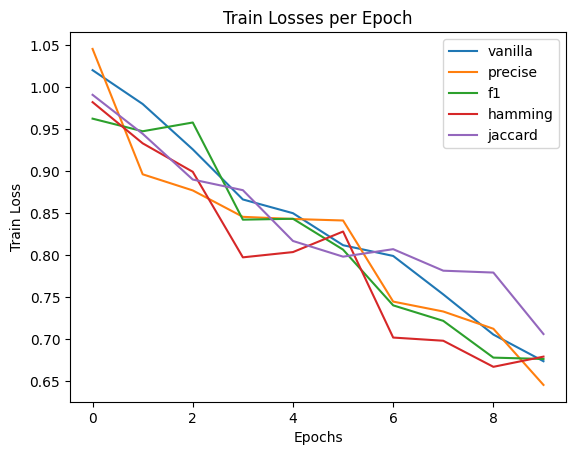

In [ ]:
import matplotlib.pyplot as plt

#plot training loss
epochs = range(0, len(vanilla_losses) )  # Assuming all models have the same number of epochs

plt.plot(epochs, vanilla_losses, label='vanilla')
plt.plot(epochs, precise_losses, label='precise')
plt.plot(epochs, f1_losses, label='f1')
plt.plot(epochs, hamming_losses, label='hamming')
plt.plot(epochs, jaccard_losses, label='jaccard')

plt.title('Train Losses per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

plt.show()

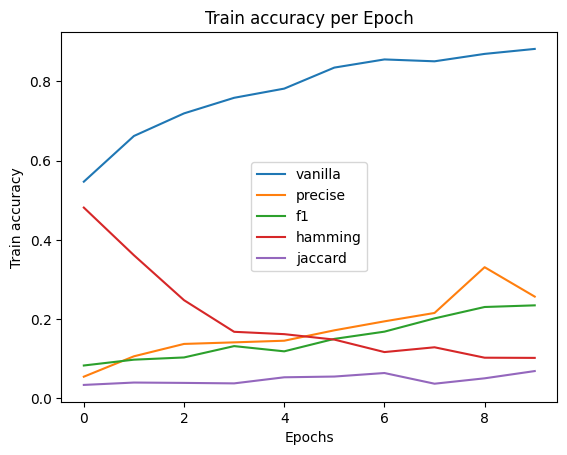

In [ ]:
import matplotlib.pyplot as plt

#plot training loss
epochs = range(0, len(vanilla_losses) )  # Assuming all models have the same number of epochs

plt.plot(epochs, vanilla_accs, label='vanilla')
plt.plot(epochs, precise_accs, label='precise')
plt.plot(epochs, f1_accs, label='f1')
plt.plot(epochs, hamming_accs, label='hamming')
plt.plot(epochs, jaccard_accs, label='jaccard')

plt.title('Train accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Train accuracy')
plt.legend()

plt.show()

## validation visualizations (loss,accuracy)

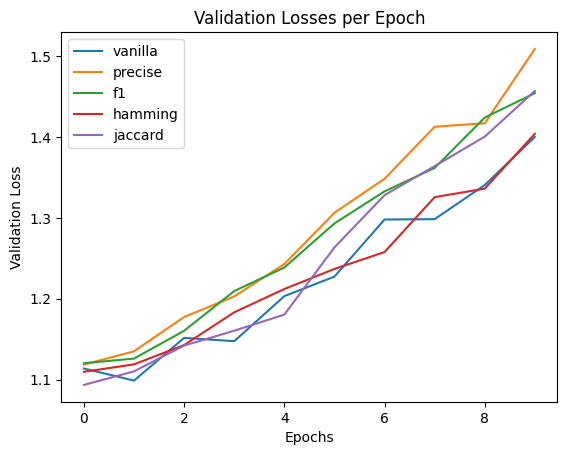

In [ ]:
import matplotlib.pyplot as plt

#plot training loss
epochs = range(0, len(vanilla_losses) )  # Assuming all models have the same number of epochs

plt.plot(epochs, vanilla_val_losses, label='vanilla')
plt.plot(epochs, precise_val_losses, label='precise')
plt.plot(epochs, f1_val_losses, label='f1')
plt.plot(epochs, hamming_val_losses, label='hamming')
plt.plot(epochs, jaccard_val_losses, label='jaccard')

plt.title('Validation Losses per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()

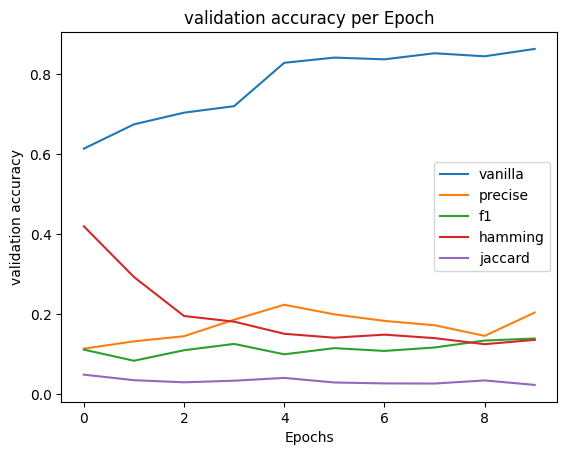

In [ ]:
import matplotlib.pyplot as plt

#plot training loss
epochs = range(0, len(vanilla_losses) )  # Assuming all models have the same number of epochs

plt.plot(epochs, vanilla_val_accs, label='vanilla')
plt.plot(epochs, precise_val_accs, label='precise')
plt.plot(epochs, f1_val_accs, label='f1')
plt.plot(epochs, hamming_val_accs, label='hamming')
plt.plot(epochs, jaccard_val_accs, label='jaccard')

plt.title('validation accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('validation accuracy')
plt.legend()

plt.show()

## evaluate how the model performs on unseen data (test set)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_and_print(model, data_loader, print_details=False):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = (logits.sigmoid() > 0.5).int()  # Apply threshold to get binary predictions

            # Add batch predictions and labels to the lists
            batch_preds = preds.cpu().numpy()
            batch_labels = labels.cpu().numpy()
            predictions.extend(batch_preds)
            true_labels.extend(batch_labels)

            # Get the disease names for the current batch
            batch_disease_names = batch['disease']

            # determine where the model got a correct prediction
            for i in range(len(batch_labels)):
                #print(f"Ground Truth: {batch_labels[i]}")
                #print(f"Prediction: {batch_preds[i]}\n")
                ground_truth = batch_labels[i]
                predict = batch_preds[i]

                predicted_symptoms_indices = np.where(predict == True)[0]
                predicted_symptoms = [dataset.index_to_symptom [x] for x in predicted_symptoms_indices]

                gt_symptoms_indices = np.where(ground_truth == True)[0]
                gt_symptoms = [dataset.index_to_symptom [x] for x in gt_symptoms_indices]

                # Get indices of mismatches between ground truth and predictions
                mismatches = (ground_truth == True) & (predict == False) #want where we missed a symptom
                mismatch_indices = np.where(mismatches)[0]
                #get indicies of correct symptoms
                matches = (ground_truth == True) & (predict == True) #want where we missed a symptom
                match_indices = np.where(matches)[0]

                #print the symptoms it got correct/wrong by mapping where the comparison is true to the symptom dictionary.
                correct_symptoms_str = [dataset.index_to_symptom [x] for x in match_indices]
                incorrect_symptoms_str = [dataset.index_to_symptom [x] for x in mismatch_indices]

                #PRINTS SPECIFICS ABOUT WHAT WAS CORRECT/MISSED
                if print_details:
                  print("predicted disease symptoms: ", predicted_symptoms)
                  print("Ground truth symptoms: ", gt_symptoms)
                  #get number of correct/incorrect predictions
                  print('disese: ', batch_disease_names[i])
                  print("Number of correct symptoms (that the disease has): ", np.sum(matches))
                  print("Number of incorrect symptoms (that the disease has): ", np.sum(mismatches))

                  print ("Model got the following symptoms correct: ", correct_symptoms_str)
                  print ("Model missed the following symptoms: ", incorrect_symptoms_str)
                  print('\n')


    # Convert lists to numpy arrays for evaluation metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='micro')

    return accuracy, precision, recall, f1

### model overview

In [ ]:
#obtain results for vanilla model
vanilla_accuracy, vanilla_precision, vanilla_recall, vanilla_f1 = evaluate_and_print(vanilla_model, test_data_loader)
print(f"Accuracy: {vanilla_accuracy}, Precision: {vanilla_precision}, Recall: {vanilla_recall}, F1-Score: {vanilla_f1}")

Accuracy: 0.0, Precision: 0.029850746268656716, Recall: 0.08, F1-Score: 0.043478260869565216


In [1]:
#precise model
precise_accuracy, precise_precision, precise_recall, precise_f1 = evaluate_and_print(precise_model, test_data_loader)
print(f"Accuracy: {precise_accuracy}, Precision: {precise_precision}, Recall: {precise_recall}, F1-Score: {precise_f1}")

NameError: ignored

In [ ]:
#f1 model
f1_accuracy, f1_precision, f1_recall, f1_f1 = evaluate_and_print(f1_model, test_data_loader)
print(f"Accuracy: {f1_accuracy}, Precision: {f1_precision}, Recall: {f1_recall}, F1-Score: {f1_f1}")

Accuracy: 0.0, Precision: 0.07894736842105263, Recall: 0.24, F1-Score: 0.11881188118811879


In [ ]:
#hamming model
hamming_accuracy, hamming_precision, hamming_recall, hamming_f1 = evaluate_and_print(hamming_model, test_data_loader)
print(f"Accuracy: {hamming_accuracy}, Precision: {hamming_precision}, Recall: {hamming_recall}, F1-Score: {hamming_f1}")

Accuracy: 0.0, Precision: 0.05, Recall: 0.12, F1-Score: 0.07058823529411766


In [ ]:
#jaccard model
jaccard_accuracy, jaccard_precision, jaccard_recall, jaccard_f1 = evaluate_and_print(jaccard_model, test_data_loader)
print(f"Accuracy: {jaccard_accuracy}, Precision: {jaccard_precision}, Recall: {jaccard_recall}, F1-Score: {jaccard_f1}")

Accuracy: 0.0, Precision: 0.04838709677419355, Recall: 0.12, F1-Score: 0.0689655172413793


### model detailed results

In [ ]:
#obtain results for vanilla model
vanilla_accuracy, vanilla_precision, vanilla_recall, vanilla_f1 = evaluate_and_print(vanilla_model, test_data_loader, True)
print(f"Accuracy: {vanilla_accuracy}, Precision: {vanilla_precision}, Recall: {vanilla_recall}, F1-Score: {vanilla_f1}")

predicted disease symptoms:  ['itching', 'vomiting', 'burning_micturition', 'fatigue', 'high_fever', 'sunken_eyes', 'breathlessness', 'yellowish_skin', 'dark_urine', 'nausea', 'abdominal_pain', 'diarrhoea', 'yellowing_of_eyes', 'chest_pain', 'fast_heart_rate', 'mucoid_sputum', 'receiving_blood_transfusion', 'receiving_unsterile_injections']
Ground truth symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']
disese:  acne
Number of correct symptoms (that the disease has):  0
Number of incorrect symptoms (that the disease has):  4
Model got the following symptoms correct:  []
Model missed the following symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']


predicted disease symptoms:  ['itching', 'chills', 'vomiting', 'fatigue', 'yellowish_skin', 'dark_urine', 'abdominal_pain', 'diarrhoea']
Ground truth symptoms:  ['skin_rash', 'high_fever', 'blister', 'red_sore_around_nose', 'yellow_crust_ooze']
disese:  impetigo
Number of correct symptoms (that the

In [ ]:
#precise model
precise_accuracy, precise_precision, precise_recall, precise_f1 = evaluate_and_print(precise_model, test_data_loader, True)
print(f"Accuracy: {precise_accuracy}, Precision: {precise_precision}, Recall: {precise_recall}, F1-Score: {precise_f1}")

predicted disease symptoms:  ['itching', 'vomiting', 'fatigue', 'mood_swings', 'yellowish_skin', 'dark_urine', 'diarrhoea', 'hip_joint_pain', 'swelling_joints', 'abnormal_menstruation']
Ground truth symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']
disese:  acne
Number of correct symptoms (that the disease has):  0
Number of incorrect symptoms (that the disease has):  4
Model got the following symptoms correct:  []
Model missed the following symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']


predicted disease symptoms:  ['skin_rash', 'joint_pain', 'vomiting', 'fatigue', 'mood_swings', 'high_fever', 'headache', 'diarrhoea', 'bruising', 'hip_joint_pain', 'swelling_joints', 'abnormal_menstruation', 'painful_walking']
Ground truth symptoms:  ['skin_rash', 'high_fever', 'blister', 'red_sore_around_nose', 'yellow_crust_ooze']
disese:  impetigo
Number of correct symptoms (that the disease has):  2
Number of incorrect symptoms (that the disease ha

In [ ]:
#f1 model
f1_accuracy, f1_precision, f1_recall, f1_f1 = evaluate_and_print(f1_model, test_data_loader, True)
print(f"Accuracy: {f1_accuracy}, Precision: {f1_precision}, Recall: {f1_recall}, F1-Score: {f1_f1}")

predicted disease symptoms:  ['itching', 'skin_rash', 'joint_pain', 'stomach_pain', 'vomiting', 'fatigue', 'weight_loss', 'high_fever', 'sweating', 'yellowish_skin', 'dark_urine', 'nausea', 'abdominal_pain', 'diarrhoea', 'fast_heart_rate', 'excessive_hunger', 'rusty_sputum']
Ground truth symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']
disese:  acne
Number of correct symptoms (that the disease has):  1
Number of incorrect symptoms (that the disease has):  3
Model got the following symptoms correct:  ['skin_rash']
Model missed the following symptoms:  ['pus_filled_pimples', 'blackheads', 'scurring']


predicted disease symptoms:  ['itching', 'skin_rash', 'chills', 'joint_pain', 'stomach_pain', 'vomiting', 'fatigue', 'high_fever', 'breathlessness', 'dark_urine', 'nausea', 'constipation', 'abdominal_pain', 'diarrhoea', 'muscle_pain']
Ground truth symptoms:  ['skin_rash', 'high_fever', 'blister', 'red_sore_around_nose', 'yellow_crust_ooze']
disese:  impetigo
Number 

In [ ]:
#hamming model
hamming_accuracy, hamming_precision, hamming_recall, hamming_f1 = evaluate_and_print(hamming_model, test_data_loader, True)
print(f"Accuracy: {hamming_accuracy}, Precision: {hamming_precision}, Recall: {hamming_recall}, F1-Score: {hamming_f1}")

predicted disease symptoms:  ['itching', 'stomach_pain', 'vomiting', 'burning_micturition', 'spotting_urination', 'cough', 'breathlessness', 'yellowish_skin', 'chest_pain', 'fast_heart_rate', 'neck_pain', 'dizziness', 'muscle_weakness', 'visual_disturbances']
Ground truth symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']
disese:  acne
Number of correct symptoms (that the disease has):  0
Number of incorrect symptoms (that the disease has):  4
Model got the following symptoms correct:  []
Model missed the following symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']


predicted disease symptoms:  ['itching', 'skin_rash', 'stomach_pain', 'vomiting', 'burning_micturition', 'fatigue', 'breathlessness', 'yellowish_skin', 'yellowing_of_eyes', 'neck_pain', 'family_history']
Ground truth symptoms:  ['skin_rash', 'high_fever', 'blister', 'red_sore_around_nose', 'yellow_crust_ooze']
disese:  impetigo
Number of correct symptoms (that the disease has):  

In [ ]:
#jaccard model
jaccard_accuracy, jaccard_precision, jaccard_recall, jaccard_f1 = evaluate_and_print(jaccard_model, test_data_loader, True)
print(f"Accuracy: {jaccard_accuracy}, Precision: {jaccard_precision}, Recall: {jaccard_recall}, F1-Score: {jaccard_f1}")

predicted disease symptoms:  ['vomiting', 'fatigue', 'weight_loss', 'high_fever', 'sweating', 'yellowish_skin', 'cramps', 'bruising', 'obesity', 'loss_of_balance', 'weakness_of_one_body_side', 'increased_appetite', 'polyuria', 'history_of_alcohol_consumption']
Ground truth symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']
disese:  acne
Number of correct symptoms (that the disease has):  0
Number of incorrect symptoms (that the disease has):  4
Model got the following symptoms correct:  []
Model missed the following symptoms:  ['skin_rash', 'pus_filled_pimples', 'blackheads', 'scurring']


predicted disease symptoms:  ['vomiting', 'fatigue', 'weight_loss', 'high_fever', 'sweating', 'yellowish_skin', 'nausea', 'cramps', 'bruising', 'obesity', 'weakness_of_one_body_side', 'increased_appetite', 'polyuria']
Ground truth symptoms:  ['skin_rash', 'high_fever', 'blister', 'red_sore_around_nose', 'yellow_crust_ooze']
disese:  impetigo
Number of correct symptoms (that the 

### double check data and labels

In [ ]:
def check_training(model,data_loader):
  # Assuming model is your trained model, data_loader is your DataLoader
  model.eval()  # Set the model to evaluation mode

  # We'll store the results in these lists
  sample_outputs = []
  sample_labels = []

  with torch.no_grad():
      for i, batch in enumerate(data_loader):
          if i >= 1:  # Stop after 3 samples
              break

          batch_disease_names = batch['disease']

          # Extract data and move tensors to the same device as the model
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          # Forward pass
          outputs = model(input_ids, attention_mask=attention_mask)

          # Store outputs and labels

          logits = outputs.logits
          sample_outputs.append(logits)
          sample_labels.append(labels)

          preds = (logits.sigmoid() > 0.5).int()
          batch_preds = preds.cpu().numpy()
          batch_labels = labels.cpu().numpy()

          for i in range(len(batch_preds)):
                if i >= 3:  # Stop after 3 samples
                  break
                # print('disese: ', batch_disease_names[i])
                # #print(f"Ground Truth: {labels[i]}")
                # #print(f"Prediction: {batch_preds[i]}\n")
                ground_truth = batch_labels[i]
                predict = batch_preds[i]

                # predicted_symptoms_indices = np.where(predict == True)[0]

                # symtptom_strs= [dataset.index_to_symptom [x] for x in predicted_symptoms_indices]

                # print('predicted symtoms: ', symtptom_strs)

                # gt_symptoms_indices = np.where(ground_truth == True)[0]
                # gt_symptoms = [dataset.index_to_symptom [x] for x in gt_symptoms_indices]
                # print("Ground truth symptoms: ", gt_symptoms)
                predicted_symptoms_indices = np.where(predict == True)[0]
                predicted_symptoms = [dataset.index_to_symptom [x] for x in predicted_symptoms_indices]
                print("predicted disease symptoms: ", predicted_symptoms)

                gt_symptoms_indices = np.where(ground_truth == True)[0]
                gt_symptoms = [dataset.index_to_symptom [x] for x in gt_symptoms_indices]
                print("Ground truth symptoms: ", gt_symptoms)

                # Get indices of mismatches between ground truth and predictions
                mismatches = (ground_truth == True) & (predict == False) #want where we missed a symptom AND where we predicted too many symptoms
                mismatch_indices = np.where(mismatches)[0]
                #get indicies of correct symptoms
                matches = (ground_truth == True) & (predict == True) #want where we missed a symptom
                match_indices = np.where(matches)[0]

                #get number of correct/incorrect predictions
                print('disese: ', batch_disease_names[i])
                print("Number of correct symptoms (that the disease has): ", np.sum(matches))
                print("Number of incorrect symptoms (that the disease has): ", np.sum(mismatches))

                #print the symptoms it got correct/wrong by mapping where the comparison is true to the symptom dictionary.
                correct_symptoms_str = [dataset.index_to_symptom [x] for x in match_indices]
                incorrect_symptoms_str = [dataset.index_to_symptom [x] for x in mismatch_indices]

                print ("Model got the following symptoms correct: ", correct_symptoms_str)
                print ("Model missed the following symptoms: ", incorrect_symptoms_str)
                print('\n')



  # Now sample_outputs and sample_labels have the outputs and labels of the first 3 samples


In [ ]:
check_training(vanilla_model, train_loader)

predicted disease symptoms:  ['itching', 'stomach_pain', 'vomiting', 'fatigue', 'breathlessness', 'yellowish_skin', 'dark_urine', 'nausea', 'abdominal_pain', 'diarrhoea', 'yellowing_of_eyes', 'chest_pain', 'fast_heart_rate']
Ground truth symptoms:  ['itching', 'vomiting', 'fatigue', 'weight_loss', 'high_fever', 'yellowish_skin', 'dark_urine', 'abdominal_pain']
disese:  jaundice
Number of correct symptoms (that the disease has):  6
Number of incorrect symptoms (that the disease has):  2
Model got the following symptoms correct:  ['itching', 'vomiting', 'fatigue', 'yellowish_skin', 'dark_urine', 'abdominal_pain']
Model missed the following symptoms:  ['weight_loss', 'high_fever']


predicted disease symptoms:  ['itching', 'acidity', 'weight_gain', 'mood_swings', 'weight_loss', 'lethargy', 'high_fever', 'sunken_eyes', 'indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea', 'abdominal_pain', 'diarrhoea', 'yellowing_of_eyes', 'chest_pain', 'fast_heart_rate', 'dizziness', 'enlar

In [ ]:
check_training(precise_model, train_loader)

#Seems like something might be off with how we're calculating loss? theoretcally i think this section should be performing better?
#seems like it predicts too many symptoms

predicted disease symptoms:  ['itching', 'vomiting', 'fatigue', 'weight_loss', 'restlessness', 'irregular_sugar_level', 'sweating', 'yellowish_skin', 'dark_urine', 'abdominal_pain', 'diarrhoea', 'yellow_urine', 'fast_heart_rate', 'excessive_hunger', 'muscle_weakness', 'polyuria', 'rusty_sputum', 'distention_of_abdomen']
Ground truth symptoms:  ['fatigue', 'weight_loss', 'restlessness', 'lethargy', 'irregular_sugar_level', 'blurred_and_distorted_vision', 'obesity', 'excessive_hunger', 'increased_appetite', 'polyuria']
disese:  diabetes
Number of correct symptoms (that the disease has):  6
Number of incorrect symptoms (that the disease has):  4
Model got the following symptoms correct:  ['fatigue', 'weight_loss', 'restlessness', 'irregular_sugar_level', 'excessive_hunger', 'polyuria']
Model missed the following symptoms:  ['lethargy', 'blurred_and_distorted_vision', 'obesity', 'increased_appetite']


predicted disease symptoms:  ['nodal_skin_eruptions', 'vomiting', 'fatigue', 'yellowish_

In [ ]:
# Check a few samples to see if labels match
for i, (text, label) in enumerate(zip(dataset.texts[:5], dataset.labels[:5])):
    print(f"Disease {i}: {dataset.disease_names[i]}")
    print(f"Text: {text[:200]}...")  # Print the first 200 characters of the text
    print(f"Label: {label}")
    print("Symptoms present:")
    for idx, symptom_present in enumerate(label):
        if symptom_present == 1:
            print(f" - {dataset.index_to_symptom[idx]}")
    print("\n")


Disease 0: GERD
Text: What Is GERD?
Gastroesophageal reflux disease, or GERD, is a digestive disorder that affects the ring of muscle between your esophagus and your stomach. This ring is called the lower esophageal sphinc...
Label: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Symptoms present:
 - stomach_pain
 - acidity
 - ulcers_on_tongue
 - vomiting
 - cough
 - chest_pain


Disease 1: Tuberculosis
Text: What Is Tuberculosis?
Tuberculosis (TB) is a contagious infection that usually attacks your lungs. It can also spread to other parts of your body, like your brain and spine. A type of bacteria called ...
Label: [0, 0, 0, 0, 0, 1, 0, 0, 0,

## extract post-training features for vanilla model

In [ ]:
def extract_hidden_states_and_labels(model, data_loader, finetuned=False):
    model.eval()
    hidden_states = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            if finetuned:
                outputs = model.bert(input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            last_hidden = outputs.last_hidden_state
            hidden_states.append(last_hidden[:, 0, :].cpu())  # Using the [CLS] token representation
            labels.extend(batch['disease'])

    hidden_states = torch.cat(hidden_states, dim=0)
    return hidden_states, labels


obtain pre-training pca

In [ ]:
#Extract initial hidden_states
init_hidden_state,init_hidden_labels = extract_hidden_states_and_labels(model, data_loader)
init_hidden_states = init_hidden_states.T

obtain post-training pca

In [ ]:
# Reuse the extract_features function to get the features after training
# Extract initial features
post_feature_matrix = extract_features(vanilla_model, data_loader,finetuned = True)
post_feature_matrix = post_feature_matrix.T  # Transpose to get 768x36 #buggy

#Extract initial hidden_states
post_hidden_states, post_hidden_labels = extract_hidden_states_and_labels(vanilla_model, data_loader,finetuned = True)
post_hidden_states = post_hidden_states.T

#extract initial pooled output
post_pooled_output = extract_pooled_output(vanilla_model, data_loader,finetuned = True)
post_pooled_output = post_pooled_output.T

#check sizes
print("post fine-tuning feature matrix: ", post_feature_matrix.shape)
print("post fine-tuning hidden states: ", post_hidden_states.shape)
print("post fine-tuning pooled output: ", post_pooled_output.shape)

#save models
torch.save(post_feature_matrix, 'post_feature_matrix.pt')
torch.save(post_hidden_states, 'post_hidden_states.pt')
torch.save(post_pooled_output, 'post_pooled_output.pt')

post fine-tuning feature matrix:  torch.Size([768, 33])
post fine-tuning hidden states:  torch.Size([768, 33])
post fine-tuning pooled output:  torch.Size([768, 33])


In [ ]:
print("are pre and post training feature matrices equal: ", torch.equal(post_feature_matrix,initial_feature_matrix))
print("are pre and post training hidden states equal: ", torch.equal(post_hidden_states,init_hidden_states))
print("are pre and post training pooled_output equal: ", torch.equal(post_pooled_output,init_pooled_output))

are pre and post training feature matrices equal:  False
are pre and post training hidden states equal:  False
are pre and post training pooled_output equal:  False


## PCA

pre finetuning

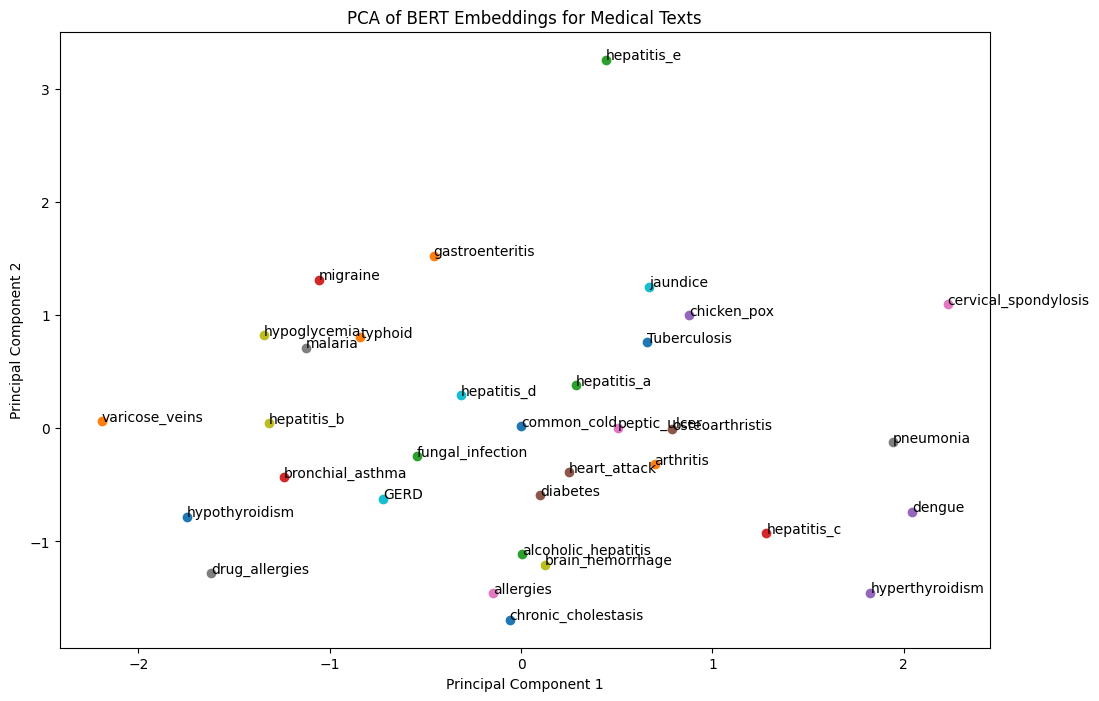

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
embeddings = init_hidden_states
labels = init_hidden_labels
reduced_embeddings = pca.fit_transform(embeddings.numpy())

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of BERT Embeddings for Medical Texts')
plt.show()

post fine tuning

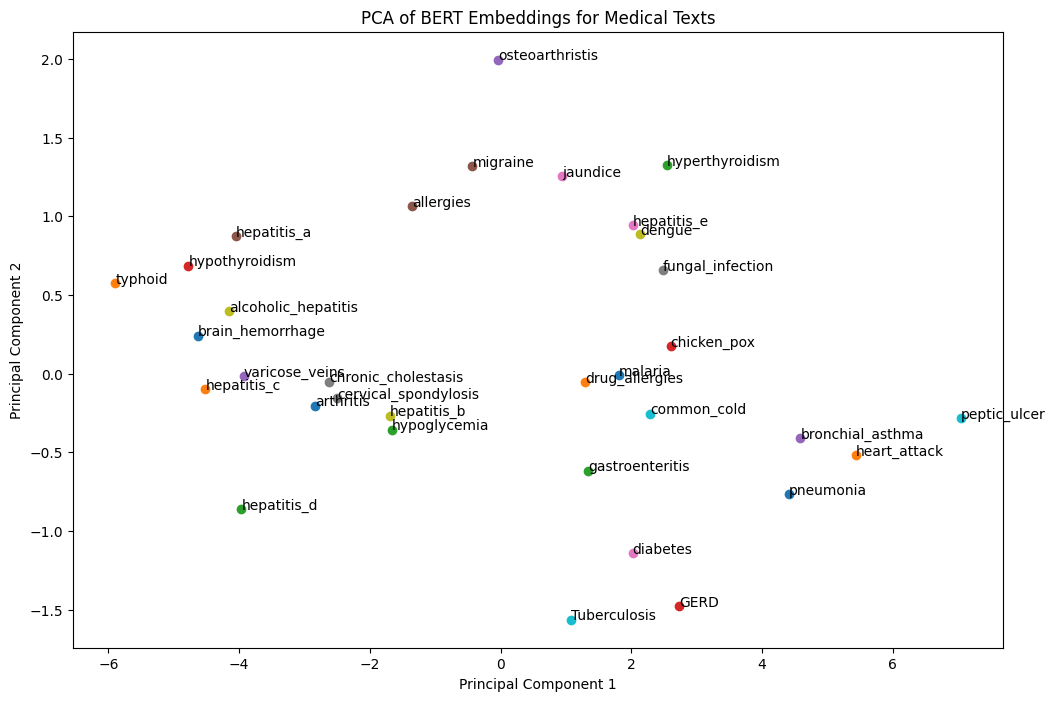

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
embeddings = post_hidden_states
labels = post_hidden_labels
reduced_embeddings = pca.fit_transform(embeddings.numpy())

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of BERT Embeddings for Medical Texts')
plt.show()


In [ ]:
import numpy as np
import plotly.express as px

unique_labels = np.unique(labels)
colors = px.colors.qualitative.Plotly  # Using Plotly's qualitative color scale
label_color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}
point_colors = [label_color_map[label] for label in labels]

# Scatter plot trace
scatter_trace = go.Scatter3d(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    z=reduced_embeddings[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=point_colors,  # Use the color array here
        opacity=0.8
    ),
    name='Data Points'
)

# Text trace
text_trace = go.Scatter3d(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    z=reduced_embeddings[:, 2],
    mode='text',
    text=labels,
    textposition='top center',
    name='Labels'
)

# Define the layout
layout = go.Layout(
    title='3D PCA of BERT Embeddings for Medical Texts',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    showlegend=True
)

# Combine the traces and layout
fig = go.Figure(data=[scatter_trace, text_trace], layout=layout)

# Show the plot
fig.show()


### post-fine tuning hidden states PCA and T-sNE

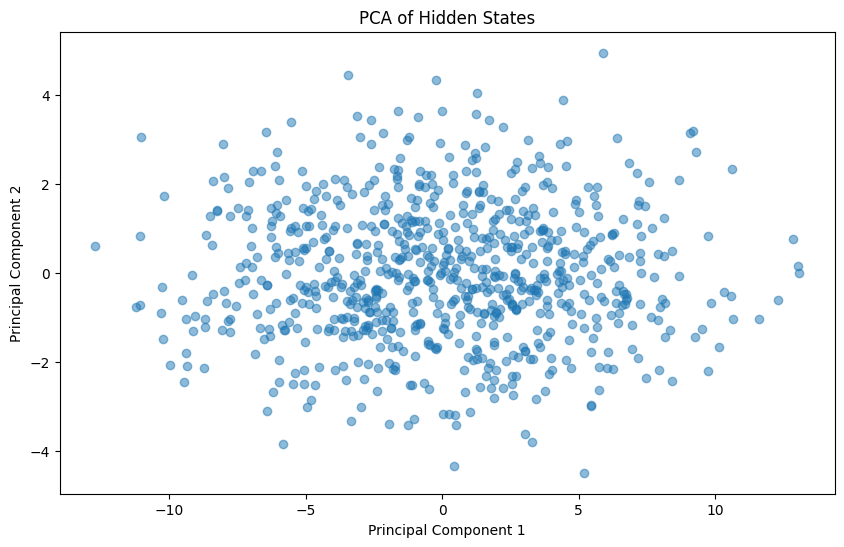

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the hidden states
hidden_states = torch.load('post_hidden_states.pt')
# Assuming hidden_states is a 3D tensor (batch_size, sequence_length, features)
# Flatten the sequence length dimension into the feature dimension
hidden_states_2d = hidden_states.reshape(-1, hidden_states.size(-1)).numpy()


scaler = StandardScaler()
scaled_data = scaler.fit_transform(hidden_states_2d)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Example visualization
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.title('PCA of Hidden States')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

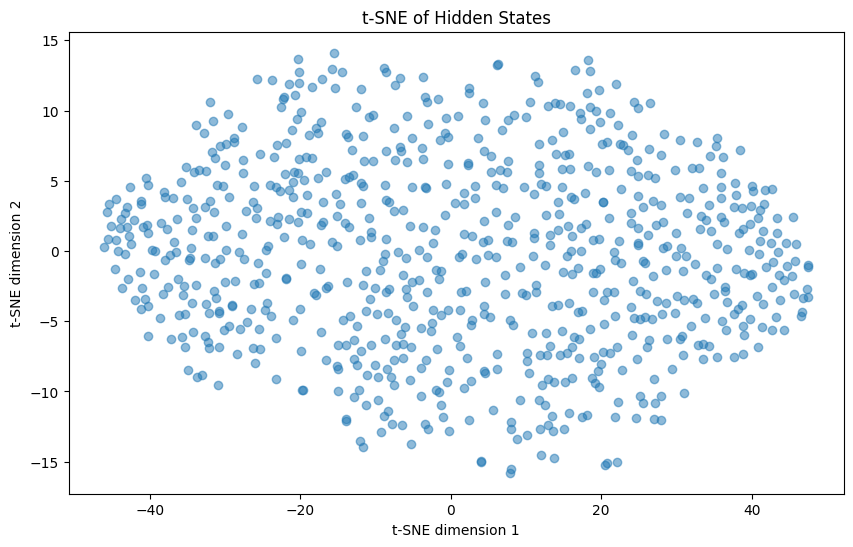

In [ ]:
#apply TSNE (non-linear)
from sklearn.manifold import TSNE

# Apply t-SNE to reduce data to 2 dimensions for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)  # Adjust parameters as needed
reduced_data_tsne = tsne.fit_transform(hidden_states_2d)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], alpha=0.5)
plt.title('t-SNE of Hidden States')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

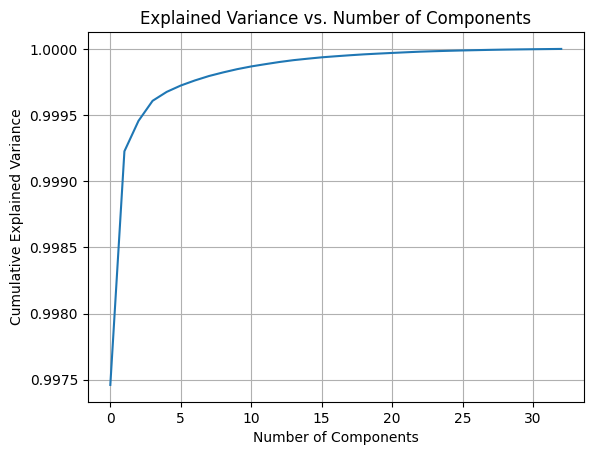

Number of components to keep: 1


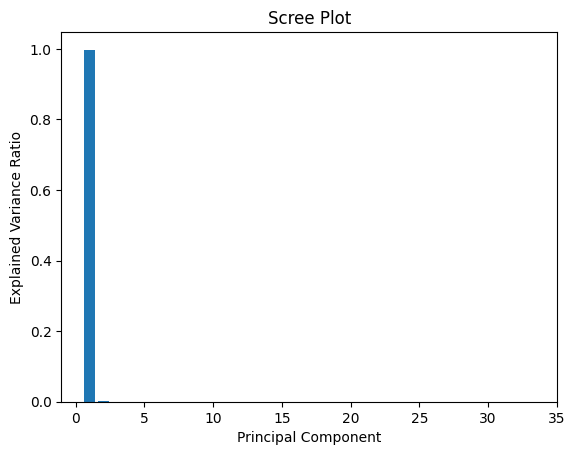

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# Load the hidden states
pooled_output = torch.load('post_pooled_output.pt')
# Assuming hidden_states is a 3D tensor (batch_size, sequence_length, features)
# Flatten the sequence length dimension into the feature dimension
pooled_output_2d = pooled_output.reshape(-1, pooled_output.size(-1)).numpy()

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA()
#reduced_data = pca.fit_transform(pooled_output_2d)
pca.fit(pooled_output_2d)

# Plot explained variance ratio to decide the number of components to keep
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Determine the number of components to keep
threshold_variance = 0.95  # Set your desired explained variance threshold
num_components_to_keep = np.argmax(cumulative_variance_ratio >= threshold_variance) + 1

print(f"Number of components to keep: {num_components_to_keep}")


#SCREE PLOT
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

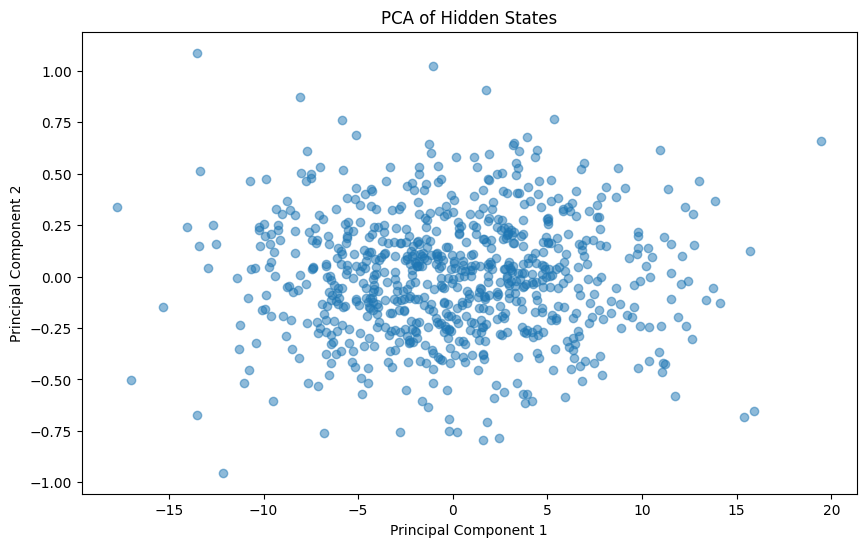

In [ ]:
# Example visualization
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
plt.title('PCA of Hidden States')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Symptom representation plots

####labels to the side

<Figure size 1000x600 with 0 Axes>

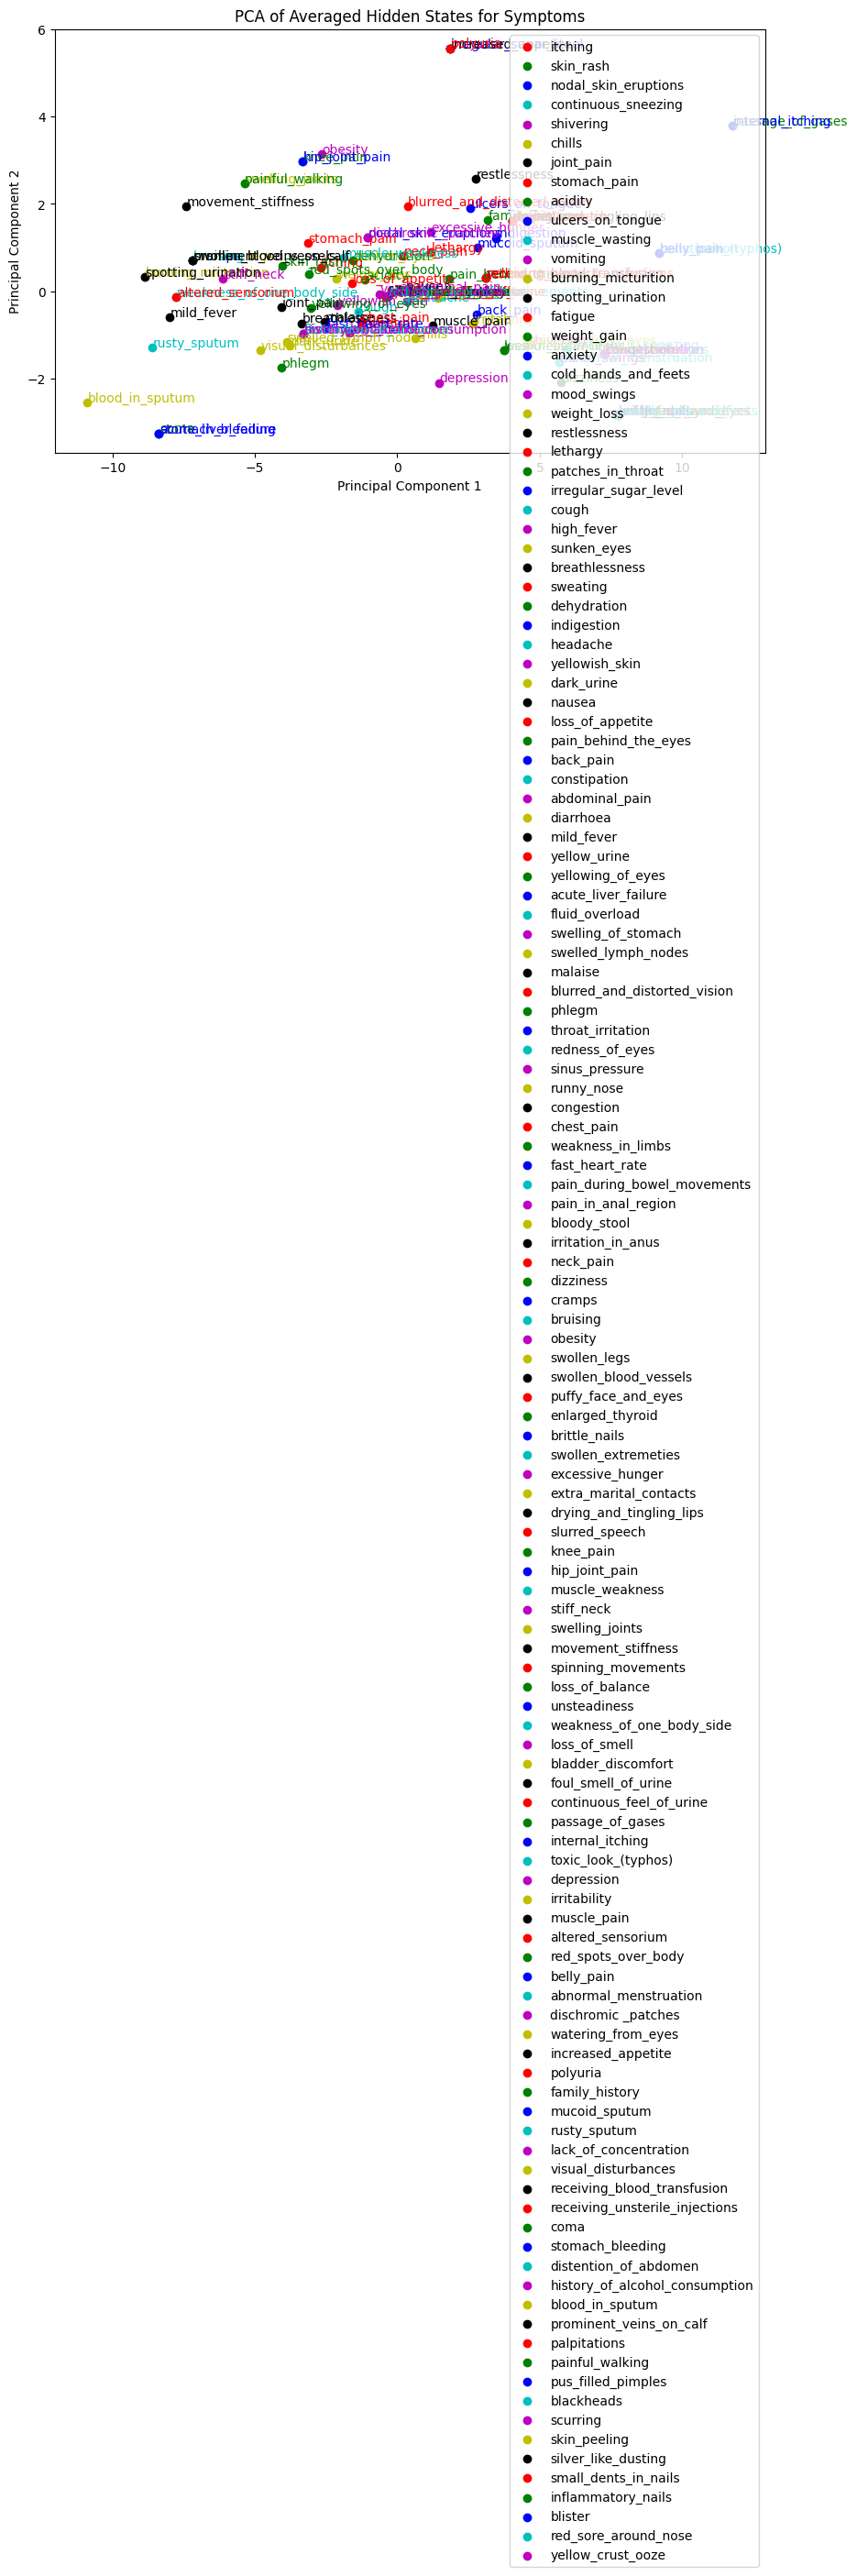

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the hidden states
hidden_states = torch.load('post_hidden_states.pt')  # Replace with your file path

# Ensure hidden_states is 2D (samples, features)
if hidden_states.dim() == 3:
    # If hidden_states is 3D, reshape it to 2D
    hidden_states = hidden_states.reshape(-1, hidden_states.size(-1))

# Create a dictionary to store summed hidden states for each symptom
symptom_hidden_states = {symptom: torch.zeros(hidden_states.size(-1)) for symptom in dataset.index_to_symptom.values()}

# Create a dictionary to count the occurrences of each symptom
symptom_counts = {symptom: 0 for symptom in dataset.index_to_symptom.values()}

# Sum the hidden states for each symptom
for i in range(len(dataset)):
    labels = dataset[i]['labels']
    for symptom_idx, present in enumerate(labels):
        if present == 1:
            symptom = dataset.index_to_symptom[symptom_idx]
            symptom_hidden_states[symptom] += hidden_states[i, :]  # Adjusting to 2D
            symptom_counts[symptom] += 1

# Average the hidden states for each symptom
for symptom in symptom_hidden_states:
    if symptom_counts[symptom] > 0:
        symptom_hidden_states[symptom] /= symptom_counts[symptom]

# Convert to a list for PCA
averaged_states = list(symptom_hidden_states.values())
averaged_states_tensor = torch.stack(averaged_states)

# Convert to 2D numpy array
averaged_states_2d = averaged_states_tensor.numpy()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(averaged_states_2d)

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Define as many colors as you have symptoms

for i, symptom in enumerate(symptom_hidden_states.keys()):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1], color=colors[i % len(colors)], label=symptom)

plt.title('PCA of Averaged Hidden States for Symptoms')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


#### labels next to points

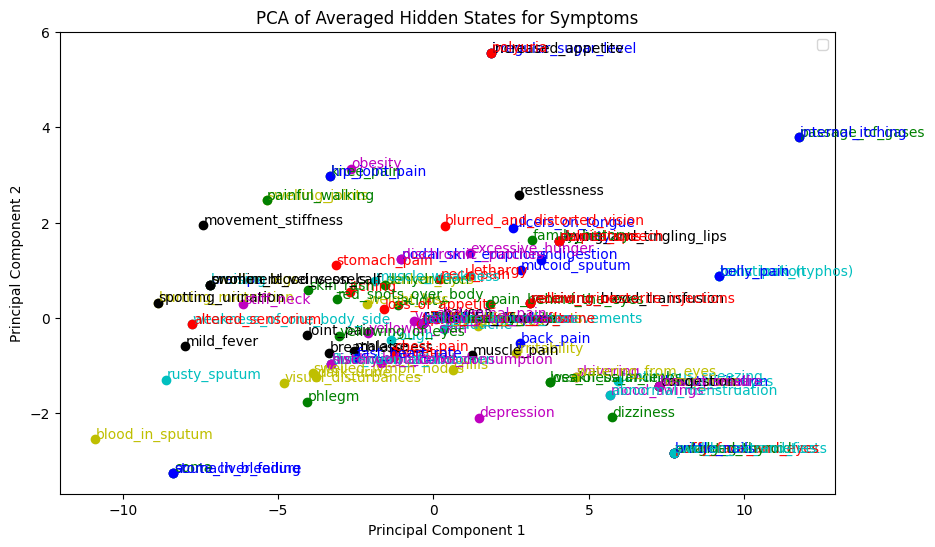

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

for i, symptom in enumerate(symptom_hidden_states.keys()):
    x, y = reduced_data[i, 0], reduced_data[i, 1]
    color = colors[i % len(colors)]
    plt.scatter(x, y, color=color)

    # Add labels off the graph
    offset = 0.02  # Adjust this value to control the label position
    ax.annotate(symptom, (x + offset, y + offset), color=color)

plt.title('PCA of Averaged Hidden States for Symptoms')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


####3d plot for symptoms (labeled)

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# ... (previous code remains the same) ...

# Apply PCA with three components
pca = PCA(n_components=3)  # Change to 3 components
reduced_data = pca.fit_transform(scaled_data)

# Create a DataFrame for plotting
import pandas as pd
df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])
df['Symptom'] = list(symptom_hidden_states.keys())

# Define colors for symptoms
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']  # Define as many colors as you have symptoms

# Create an interactive 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Symptom', color_discrete_sequence=colors, text='Symptom')

# Customize the layout
fig.update_layout(
    title='PCA of Averaged Hidden States for Symptoms (Interactive 3D)',
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3',
    )
)

# Show the interactive 3D plot
fig.show()


### diseases based on symptoms

#### 2d plot

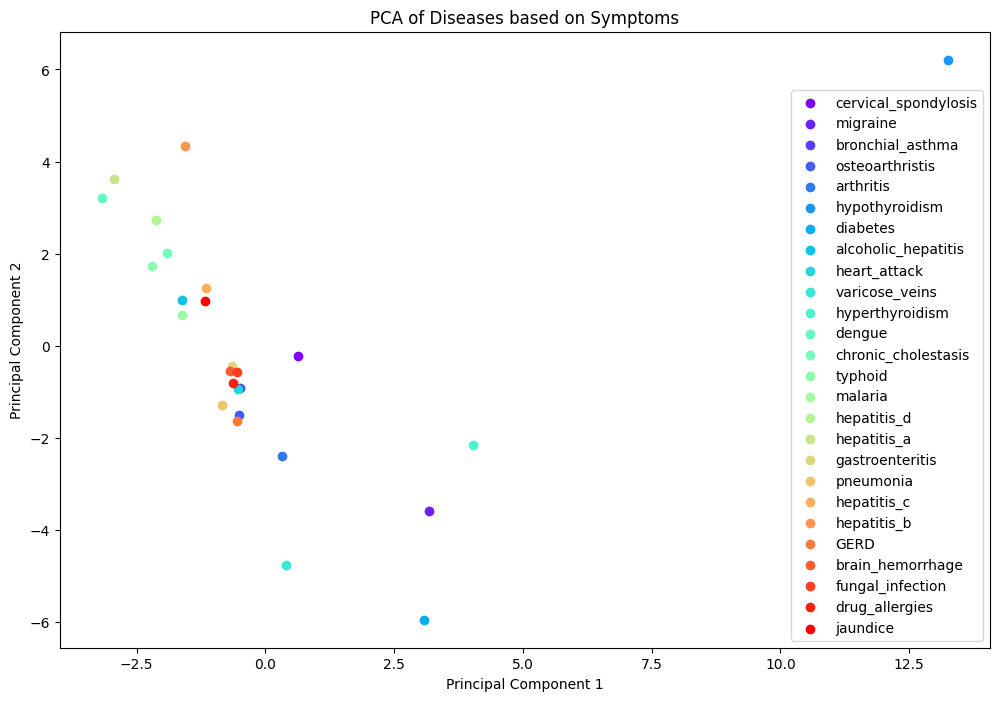

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#hopefully this is consistent everytime it's called/ doesnt re-randomly initialize
dataset = train_dataset

# Assuming 'symptom_encodings' and 'disease_names' are available
symptom_encodings = []
disease_names = []
for i,_ in enumerate(dataset):
    symptom_encodings.append(dataset[i]['labels'].numpy() )
    disease_names.append(dataset[i]['disease'])


# Standardize the data
scaler = StandardScaler()
symptom_encodings_std = scaler.fit_transform(symptom_encodings)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(symptom_encodings_std)

# Plotting
plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(disease_names)))

for i, (pc1, pc2) in enumerate(principal_components):
    plt.scatter(pc1, pc2, color=colors[i], label=disease_names[i])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diseases based on Symptoms')
plt.legend()  # Remove if too cluttered
plt.show()


#### 3d plot

In [ ]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'symptom_encodings' and 'disease_names' are available
symptom_encodings = []
disease_names = []
for i, _ in enumerate(dataset):
    symptom_encodings.append(dataset[i]['labels'].numpy())
    disease_names.append(dataset[i]['disease'])

# Standardize the data
scaler = StandardScaler()
symptom_encodings_std = scaler.fit_transform(symptom_encodings)

# Apply PCA with three components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(symptom_encodings_std)

# Create a DataFrame for plotting
import pandas as pd
df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df['Disease'] = disease_names

# Create a color map based on unique disease names
color_map = {disease: i for i, disease in enumerate(pd.unique(df['Disease']))}
df['Color'] = df['Disease'].map(color_map)

# Create an interactive 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', text='Disease', color='Color',
                     color_continuous_scale='Viridis', title='PCA of Diseases based on Symptoms (Interactive 3D)')

# Customize the layout
fig.update_layout(scene=dict(xaxis_title='Principal Component 1',
                             yaxis_title='Principal Component 2',
                             zaxis_title='Principal Component 3'),
                  coloraxis_colorbar=dict(title='Disease Color'))

# Show the interactive 3D plot
fig.show()
